In [1]:
# Install required libraries
!pip install transformers datasets sentencepiece nltk
!pip install py7zr
!pip install pd
!pip install evaluate
!pip install rouge_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 60.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.7/413.7 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=73687a605e1910658536514db3f60e660f72d7c9fa8e95f9264317b71cab1d7e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [13]:
# Import necessary libraries
import torch
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
from collections import Counter
import seaborn as sns
import pandas as pd
import evaluate


In [3]:
# Ensure GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


In [4]:
# Load SAMSum dataset
dataset = load_dataset("samsum")
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N]  y


corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

{'id': '13818513', 'dialogue': "Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)", 'summary': 'Amanda baked cookies and will bring Jerry some tomorrow.'}


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


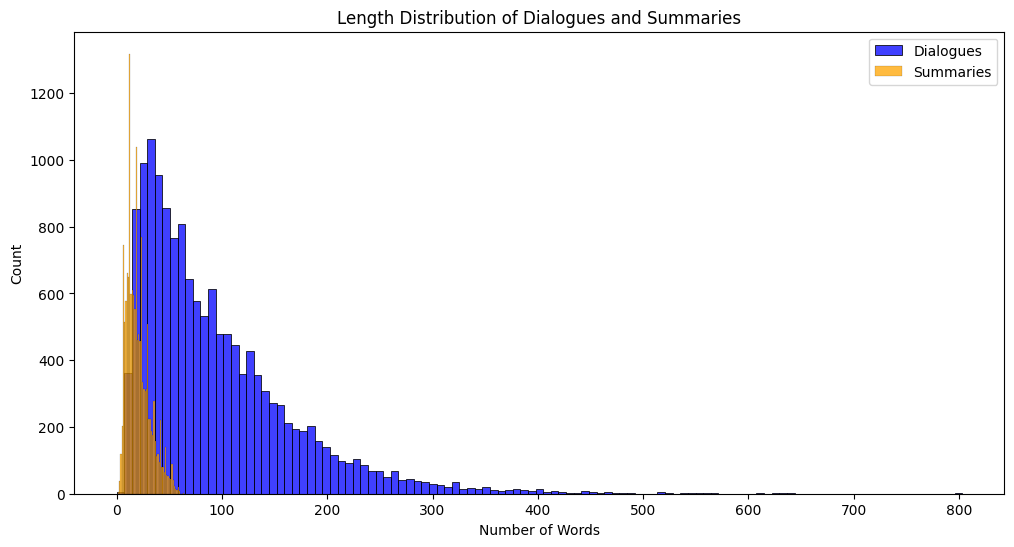

In [5]:
# Check the structure of the first entry in the dataset
print(train_data[0])

# (b) Plot the Length Distribution of Dialogues and Summaries
dialogue_lengths = [len(dialogue['dialogue'].split()) for dialogue in train_data]
summary_lengths = [len(dialogue['summary'].split()) for dialogue in train_data]

# Plot the length distributions
plt.figure(figsize=(12, 6))
sns.histplot(dialogue_lengths, color='blue', label='Dialogues')
sns.histplot(summary_lengths, color='orange', label='Summaries')
plt.title("Length Distribution of Dialogues and Summaries")
plt.xlabel("Number of Words")
plt.legend()
plt.show()

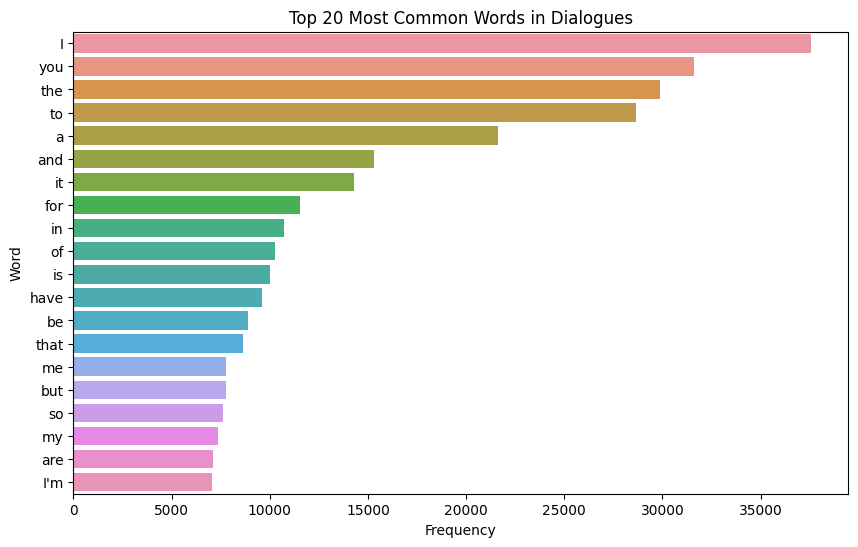

In [6]:
# (c) 20 Most Common Words in Dialogues
all_dialogue_words = ' '.join([dialogue['dialogue'] for dialogue in train_data]).split()
common_words = Counter(all_dialogue_words).most_common(20)
# Convert the results to a DataFrame for better plotting with Seaborn
df_common_words = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

# Plot the top 20 most common words using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Frequency', y='Word', data=df_common_words)
plt.title("Top 20 Most Common Words in Dialogues")
plt.show()



In [7]:
# Inference with Pre-trained Models
# Load Pre-trained Models (e.g., BART, T5)
models = ["facebook/bart-large-cnn", "t5-large", "google/pegasus-large"]
model_pipelines = {}

for model_name in models:
    print(f"Loading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer, device=0 if device == 'cuda' else -1)
    model_pipelines[model_name] = summarizer

Loading model: facebook/bart-large-cnn


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

Loading model: t5-large


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Loading model: google/pegasus-large


tokenizer_config.json:   0%|          | 0.00/88.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/3.09k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-large and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [8]:
# Generate summaries for a few dialogues and compare
sample_dialogues = [train_data[i]['dialogue'] for i in range(3)]
for model_name, summarizer in model_pipelines.items():
    print(f"\nSummaries using {model_name}:\n")
    for dialogue in sample_dialogues:
        summary = summarizer(dialogue, max_length=50, min_length=10, do_sample=False)
        print(f"Dialogue: {dialogue}\nSummary: {summary[0]['summary_text']}\n")


Your max_length is set to 50, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)



Summaries using facebook/bart-large-cnn:



Your max_length is set to 50, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)


Dialogue: Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Summary: Amanda: I baked  cookies. Do you want some? Jerry: Sure!

Dialogue: Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great
Summary: Olivia asks Oliver who he is voting for in the election. Oliver says he's voting for Liberals as always. Olivia asks him who he will be voting for.



Your max_length is set to 50, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)


Dialogue: Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style
Summary: Kim: I was going to do lots of stuff but ended up procrastinating. Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores. Kim: Maybe tomorrow I'll move my ass and do


Summaries using t5-large:



Your max_length is set to 50, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)


Dialogue: Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Summary: Amanda: i baked cookies. do you want some? Jerry: sure! :-)

Dialogue: Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great
Summary: liberals as always - who are you voting for in this election? olivia: 'liberals as always'



Your max_length is set to 50, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)


Dialogue: Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style
Summary: Kim: i was going to do lots of stuff but ended up procrastinating . for doing stuff i recommend pomodoro technique where u use breaks for doing chores .


Summaries using google/pegasus-large:



Your max_length is set to 50, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)


Dialogue: Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Summary: Amanda: I'll bring you tomorrow :-)

Dialogue: Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great
Summary: Oliver: Me too!! Olivia: Me too!!

Dialogue: Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style
Summary: Kim: Oh you know, uni stuff and unfucking my room Kim: Maybe tomorrow I'll move my ass and do everything Kim: We were going to defrost a fridge so in

In [9]:
def lead_3_baseline(text):
    sentences = sent_tokenize(text)
    return ' '.join(sentences[:3])

In [14]:
# Evaluate Lead-3 Baseline on the same dialogues
print("\nLead-3 Baseline Summaries:")
for dialogue in sample_dialogues:
    print(f"Dialogue: {dialogue}\nLead-3 Summary: {lead_3_baseline(dialogue)}\n")


Lead-3 Baseline Summaries:
Dialogue: Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)
Lead-3 Summary: Amanda: I baked  cookies. Do you want some? Jerry: Sure!

Dialogue: Olivia: Who are you voting for in this election? 
Oliver: Liberals as always.
Olivia: Me too!!
Oliver: Great
Lead-3 Summary: Olivia: Who are you voting for in this election? Oliver: Liberals as always. Olivia: Me too!!

Dialogue: Tim: Hi, what's up?
Kim: Bad mood tbh, I was going to do lots of stuff but ended up procrastinating
Tim: What did you plan on doing?
Kim: Oh you know, uni stuff and unfucking my room
Kim: Maybe tomorrow I'll move my ass and do everything
Kim: We were going to defrost a fridge so instead of shopping I'll eat some defrosted veggies
Tim: For doing stuff I recommend Pomodoro technique where u use breaks for doing chores
Tim: It really helps
Kim: thanks, maybe I'll do that
Tim: I also like using post-its in kaban style
Lead-3 Summary: Tim: Hi, what's up?

In [15]:
rouge = evaluate.load("rouge")

In [16]:
# Generate summaries and compute ROUGE for each model
def compute_rouge(reference_summaries, generated_summaries):
    return rouge.compute(predictions=generated_summaries, references=reference_summaries)


In [17]:
# For a quick comparison on the sample dialogues
reference_summaries = [train_data[i]['summary'] for i in range(3)]

# Compute ROUGE scores for each model
for model_name, summarizer in model_pipelines.items():
    generated_summaries = [summarizer(dialogue, max_length=50, min_length=10, do_sample=False)[0]['summary_text'] for dialogue in sample_dialogues]
    rouge_score = compute_rouge(reference_summaries, generated_summaries)
    print(f"\nROUGE Score for {model_name}: {rouge_score}")

Your max_length is set to 50, but your input_length is only 31. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)
Your max_length is set to 50, but your input_length is only 38. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=19)
Your max_length is set to 50, but your input_length is only 30. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=15)



ROUGE Score for facebook/bart-large-cnn: {'rouge1': 0.3549257759784075, 'rouge2': 0.08858505564387918, 'rougeL': 0.2642825011246064, 'rougeLsum': 0.2642825011246064}


Your max_length is set to 50, but your input_length is only 29. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=14)
Your max_length is set to 50, but your input_length is only 25. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=12)



ROUGE Score for t5-large: {'rouge1': 0.47007274283269146, 'rouge2': 0.14326622510765732, 'rougeL': 0.3491313649978605, 'rougeLsum': 0.3491313649978605}


Your max_length is set to 50, but your input_length is only 26. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=13)



ROUGE Score for google/pegasus-large: {'rouge1': 0.21346153846153848, 'rouge2': 0.0, 'rougeL': 0.20064102564102568, 'rougeLsum': 0.20064102564102568}


In [18]:
# Lead-3 Baseline ROUGE score
lead_3_summaries = [lead_3_baseline(dialogue) for dialogue in sample_dialogues]
lead_3_rouge_score = compute_rouge(reference_summaries, lead_3_summaries)
print(f"\nLead-3 Baseline ROUGE Score: {lead_3_rouge_score}")



Lead-3 Baseline ROUGE Score: {'rouge1': 0.41475483580746736, 'rouge2': 0.1283461210571185, 'rougeL': 0.34263007947218477, 'rougeLsum': 0.3540260908681961}


In [19]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

# Tokenizer and model loading
model_name = "facebook/bart-large-cnn"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [20]:
# Preprocessing the dataset for fine-tuning
def preprocess_function(examples):
    inputs = examples["dialogue"]
    targets = examples["summary"]
    
    # Tokenize inputs and summaries, apply truncation and padding
    model_inputs = tokenizer(inputs, max_length=512, padding='max_length', truncation=True)
    
    # Tokenize labels (summaries) and also apply truncation and padding
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, padding='max_length', truncation=True)
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


# Apply preprocessing to dataset
tokenized_datasets = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:4117: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [21]:
# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,  # Enable if using GPU
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [22]:
# Define the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

# Fine-tune the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.292700,0.311392
2,0.220500,0.310354
3,0.161800,0.325192


/opt/conda/lib/python3.10/site-packages/transformers/modeling_utils.py:2618: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=11049, training_loss=0.24591592810619836, metrics={'train_runtime': 7453.8697, 'train_samples_per_second': 5.929, 'train_steps_per_second': 1.482, 'total_flos': 4.788867749747098e+16, 'train_loss': 0.24591592810619836, 'epoch': 3.0})

In [23]:
from huggingface_hub import notebook_login
notebook_login()

In [24]:
model.push_to_hub("bart-large-cnn-samson")
tokenizer.push_to_hub("bart-large-cnn-samson")

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Aayon/bart-large-cnn-samson/commit/0c8b0283c925824823eba61889f178f3a86f3016', commit_message='Upload tokenizer', commit_description='', oid='0c8b0283c925824823eba61889f178f3a86f3016', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Aayon/bart-large-cnn-samson', endpoint='https://huggingface.co', repo_type='model', repo_id='Aayon/bart-large-cnn-samson'), pr_revision=None, pr_num=None)

In [26]:
# Generate summaries using the fine-tuned model
fine_tuned_summaries = [trainer.model.generate(tokenizer(dialogue, return_tensors="pt").input_ids.to(device)) for dialogue in sample_dialogues]
generated_summaries = [tokenizer.decode(summary[0], skip_special_tokens=True) for summary in fine_tuned_summaries]

# Compute ROUGE for the fine-tuned model
fine_tuned_rouge_score = compute_rouge(reference_summaries, generated_summaries)
print(f"\nFine-tuned Model ROUGE Score: {fine_tuned_rouge_score}")


Fine-tuned Model ROUGE Score: {'rouge1': 0.3312143102855178, 'rouge2': 0.14959286745001033, 'rougeL': 0.25802545579635366, 'rougeLsum': 0.25802545579635366}


In [25]:
# Evaluate the fine-tuned model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")


Evaluation Results: {'eval_loss': 0.32519176602363586, 'eval_runtime': 38.6806, 'eval_samples_per_second': 21.148, 'eval_steps_per_second': 5.3, 'epoch': 3.0}
